In [12]:
# importing basic library to wrangle and explore the data
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pandas_profiling import ProfileReport
from statsmodels.tsa.seasonal import seasonal_decompose

### Importing price series

 There are two distinct sets of data. The first pertains to Brazilian spot coffee, which encompasses the price of coffee traded within coffee production regions in Brazil. This coffee is referred to as 'green bean' coffee, representing the unroasted, raw form of the bean before it undergoes roasting and grinding for consumption. 
 
 The second series represents the future price of coffee, traded in exchange. This data series focuses on expected price of coffee at a later date, based on market expectations and trends.

In [2]:
# impoting the data
path = '/Users/marciobernardo/Documents/Springboard/Projects/3rd Capstone project/dados/'

df_bra_coffee = pd.read_csv(path+'coffee_brazil.csv')

df_fut_coffee = pd.read_csv(path+'coffee_future.csv')

### Data Wrangling

In [3]:
# Brazilian spot coffee, quoted as US$ per 60 Kilos (US$/60 Kg)

df_bra_coffee = df_bra_coffee[['Data','À vista US$']].copy()

df_bra_coffee.columns = ['date','price']

df_bra_coffee['date'] = pd.to_datetime(df_bra_coffee['date'], format='%d/%m/%Y')

# Adjusting the Brazilian coffee price to cents/pounds
df_bra_coffee['price_adj'] = (df_bra_coffee['price']* 100/60)/2.20462

Brazilian spot coffee is commercialized within Brazil and is quoted in Brazilian Reais per 60-kilo bag. The "coffee_brazil.csv" file already contains a column with quotes in US dollars per 60-kilo bag. However, the future coffee market quotes are given in US cents per pound. Therefore, the 'price_adj' column represents the conversion of US dollars per 60 kilos to US cents per pound.

In [4]:
# ICE future coffee, quoted as cents per pounds (c$/lb)

df_fut_coffee = df_fut_coffee[['Date','Last Price']].copy()

df_fut_coffee.columns = ['date','price']

df_fut_coffee['date'] = pd.to_datetime(df_fut_coffee['date'], format='%m-%d-%y')

In [5]:
# Brazilian coffee basis calculation, quotes in cents per pound (c$/lb)
df_bra_basis = pd.merge(df_bra_coffee,df_fut_coffee, on = 'date',how='inner')

df_bra_basis.columns = ['date','bra','bra_adj','fut']

df_bra_basis['bra_basis'] = df_bra_basis.bra_adj - df_bra_basis.fut 

df_bra_basis.dropna(inplace = True)

# Set 'date' as the index
df_bra_basis.set_index('date', inplace=True)

DataFrame named 'df_bra_basis' includes the Brazilian spot market, the future market, and the Brazilian coffee basis time series. All of these are quoted in US cents per pound.

The basis is derived from the difference between the spot market and the future market. This series indicates the residual market risk that remains even after implementing a hedge. While a hedge reduces market risk, it doesn't eliminate it entirely. Basis risk signifies the market risk that cannot be completely eliminated. The basis is also crucial in calculating the optimal hedging ratio.

### EDA

In [6]:
df_bra_basis.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6515 entries, 1996-09-03 to 2023-08-08
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   bra        6515 non-null   float64
 1   bra_adj    6515 non-null   float64
 2   fut        6515 non-null   float64
 3   bra_basis  6515 non-null   float64
dtypes: float64(4)
memory usage: 254.5 KB


The dataset spans from September 3rd, 1996, to August 8th, 2023, comprising a total of 6515 observations in our time series. There are four distinct series within the dataset: the Brazilian spot market (quoted in US$/60 kilo), the adjusted price for the Brazilian spot market (quoted in US cents per pound), the ICE coffee future price (quoted in US cents per pound), and the Brazilian coffee basis series.

In [7]:
df_bra_basis.head()

,bra,bra_adj,fut,bra_basis
date,,,,
1996-09-03,117.69,88.972249,125.05,-36.077751
1996-09-04,117.44,88.783252,124.20,-35.416748
1996-09-05,116.38,87.981905,122.60,-34.618095
1996-09-06,115.98,87.679509,124.60,-36.920491
1996-09-09,115.11,87.021800,122.50,-35.478200


In [8]:
df_bra_basis.describe()

,bra,bra_adj,fut,bra_basis
count,6515.000000,6515.000000,6515.000000,6515.000000
mean,138.433088,104.653779,129.811604,-25.157825
std,59.825587,45.227437,49.486644,9.009344
min,30.920000,23.375155,41.500000,-98.992103
25%,103.840000,78.501813,101.875000,-29.039687
50%,127.380000,96.297775,121.100000,-23.507018
75%,169.150000,127.875401,153.350000,-19.279366
max,349.390000,264.134711,304.900000,3.641727


The basic descriptive statistics reveal that the basis series exhibits significantly lower volatility (as indicated by the lowest standard deviation) and has the narrowest range. These findings align with the concept that basis risk is notably lower than the inherent risk associated with either the spot or future market.

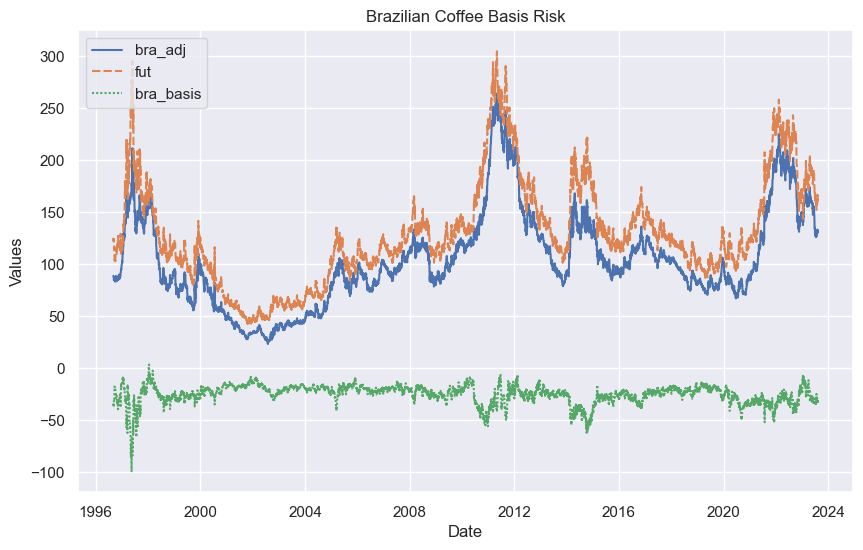

In [9]:

# Set the style
sns.set(style="darkgrid")

# Plot the line chart using Seaborn for specific columns
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
sns.lineplot(data=df_bra_basis[['bra_adj', 'fut', 'bra_basis']])
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Brazilian Coffee Basis Risk')
plt.legend(loc='upper left')
plt.show();


The chart depicting the price series visually illustrates the diminished volatility and range of the basis in comparison to both the future market and the spot market. While both the future and spot markets displayed substantial price fluctuations over the analyzed time period, the basis has consistently remained relatively stable around the -23 level.

Furthermore, this graph also highlights periods of increased volatility, distinct trends over the years, and some discernible seasonality.

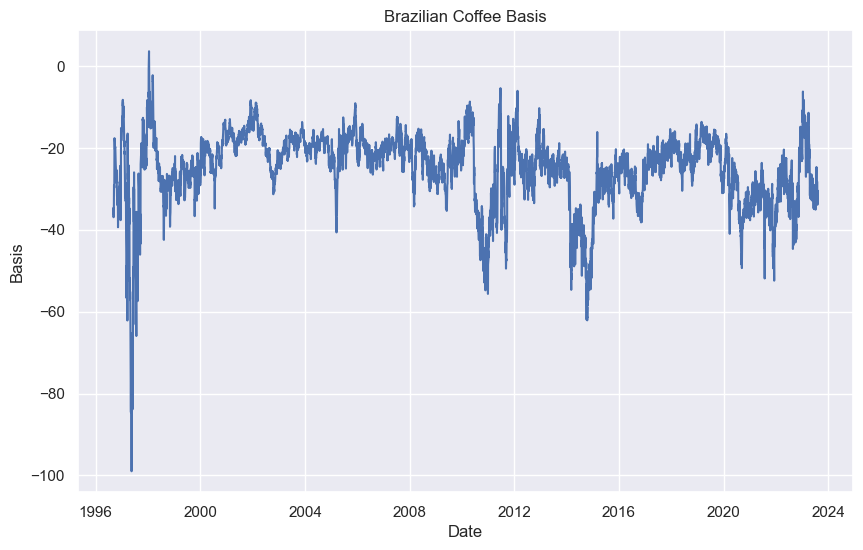

In [10]:


# Set the style
sns.set(style="darkgrid")

# Plot the line chart using Seaborn for the 'bra_basis' column
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
sns.lineplot(data=df_bra_basis['bra_basis'])
plt.xlabel('Date')
plt.ylabel('Basis')
plt.title('Brazilian Coffee Basis')
plt.show()


The chart of the Brazilian coffee basis series reveals that although the basis exhibits considerably less volatility, this series also displays clusters of increased volatility, distinct trends, and seasonal patterns.

#### Profile Report  

In [22]:
basis_profile = ProfileReport(df_bra_basis, tsmode=True)
basis_profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Based on the information presented in the report above, we can deduce that the Brazilian coffee basis risk exhibits a strong correlation with the adjusted Brazilian spot market price and the coffee future price. Moreover, the series is non-stationary and displays seasonality.

The coffee basis has the lowest coefficient of variation (-0.35) and the lowest mean absolute deviation (4.67) among the series. It also demonstrates excess kurtosis and slight skewness. The histagram of the basis looks like an assimetric t-student distribution. The mean of the basis is -25.16, with a median of -23.04.

The ACF and PACF plots indicates that the basis series has an AR and a MA component.

### Decomposition of the Brazilian Coffee Basis Series

In [45]:
basis = df_bra_basis['bra_basis'].rolling(window=21,center=True,win_type='triang').mean()
basis = basis.to_frame()
basis['doy'] = basis.index.dayofyear
basis['year'] = basis.index.year

In [47]:

piv_basis = pd.pivot_table(basis,index=['doy'],columns=['year'], values = ['bra_basis'])

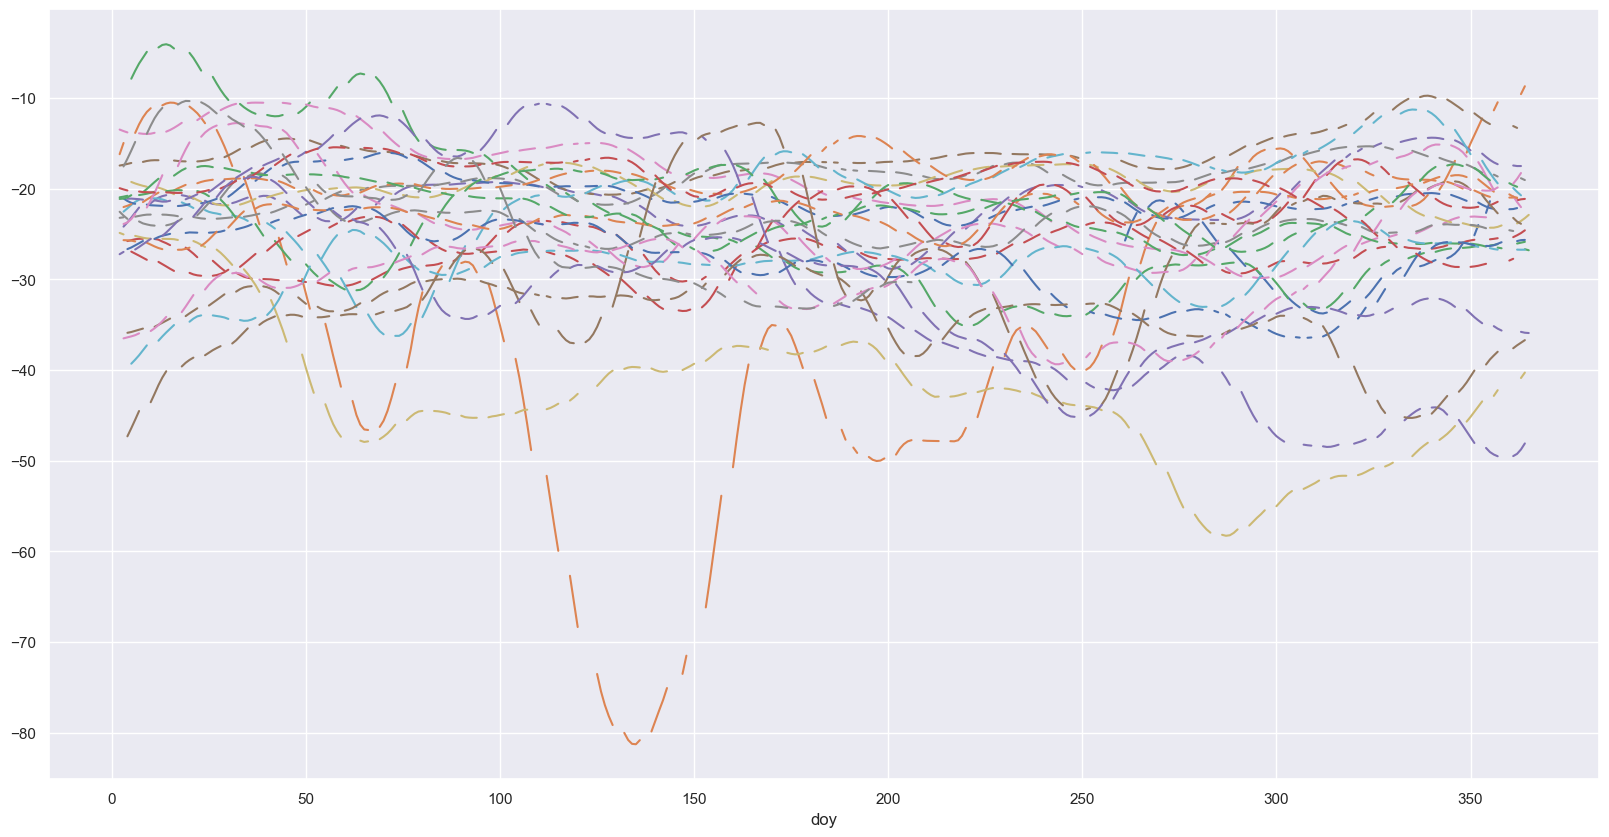

In [48]:
piv_basis.plot(figsize=(20, 10), legend = False);

The seasonality pattern isn't very clear. However, from an economic perspective, the seasonality would likely be multiplicative. Given the current conditions that already impact the market price, a seasonal effect would probably influence the price in a proportional manner rather than through a fixed added effect.

In [69]:
# Taken the absolute value of the Brazil coffee bases because the multiplicable model doesn't allow negative numbers.
basis_decom = seasonal_decompose(abs(df_bra_basis['bra_basis']), model='multiplicable', period = 251)


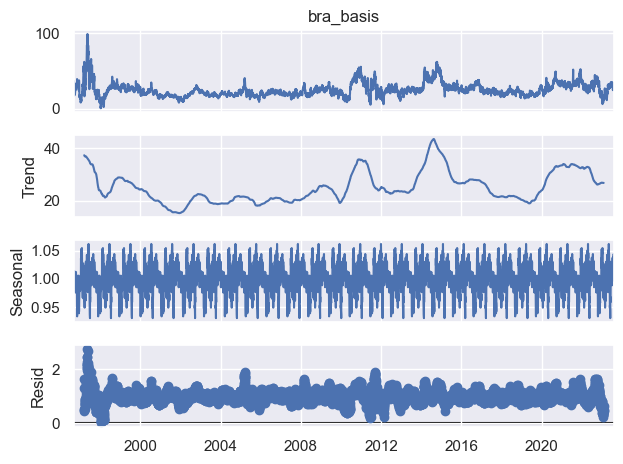

In [70]:
basis_decom.plot();

Conclusion:

The Brazilian coffee basis time series has typical financial time series properties, statistical test show that the series isn't stationary and has seasonality. Therefore, the SARIMA is a good baseline method to explore this data.